# Loading data set

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

train_dataset = datasets.MNIST(
    root="./mnist", train=True, transform=transforms.ToTensor(), download=True
)

test_dataset = datasets.MNIST(
    root="./mnist", train=False, transform=transforms.ToTensor()
)

In [4]:
len(train_dataset)

60000

In [5]:
len(test_dataset)

10000

# Create a valid dataset

In [6]:
import torch
from torch.utils.data.dataset import random_split

torch.manual_seed(1)
train_dataset, val_dataset = random_split(train_dataset, lengths=[55000, 5000])

In [8]:
train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = 64,
    shuffle = True
)

val_loader = DataLoader(
    dataset = val_dataset,
    batch_size = 64,
    shuffle = False
)

test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = 64,
    shuffle = False
)

# Check label distribution

In [12]:
from collections import Counter

"""
tolist because the batch size of loader is 64
"""
train_counter = Counter()
for images, labels in train_loader:
    train_counter.update(labels.tolist())

print("\nTraining label distribution:")
print(sorted(train_counter.items()))

val_counter = Counter()
for images, labels in val_loader:
    val_counter.update(labels.tolist())

print("\nValidating label distribution:")
print(sorted(val_counter.items()))

test_counter = Counter()
for images, labels in test_loader:
    test_counter.update(labels.tolist())
print("\nTest label distribution:")
print(sorted(test_counter.items()))
    



Training label distribution:
[(0, 5419), (1, 6185), (2, 5477), (3, 5681), (4, 5349), (5, 4974), (6, 5422), (7, 5710), (8, 5351), (9, 5432)]

Validating label distribution:
[(0, 504), (1, 557), (2, 481), (3, 450), (4, 493), (5, 447), (6, 496), (7, 555), (8, 500), (9, 517)]

Test label distribution:
[(0, 980), (1, 1135), (2, 1032), (3, 1010), (4, 982), (5, 892), (6, 958), (7, 1028), (8, 974), (9, 1009)]


# Zero-rule baseline (majority class)

In [15]:
# most_common(k most)[0] <-- find 1 most_common, an get the [0] in the return list
majority_class = test_counter.most_common(1)[0]
print("Majority class:", majority_class[0])

baseline_acc = majority_class[1] / sum(test_counter.values())
print("Accuracy when always predicting the majority class:")
print(f"{baseline_acc:.2f} ({baseline_acc * 100: .2f}%)")

Majority class: 1
Accuracy when always predicting the majority class:
0.11 ( 11.35%)


# A quick visual check

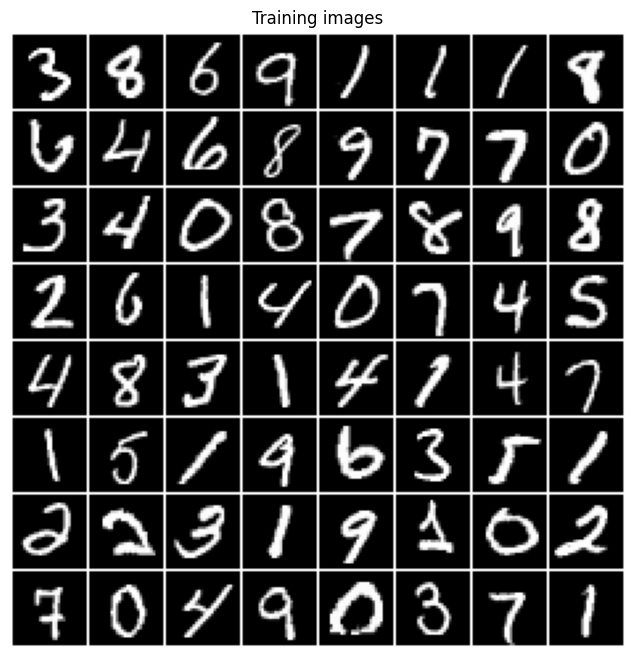

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torchvision


for images, labels in train_loader:  
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:64], 
    padding=1,
    pad_value=1.0,
    normalize=True),
    (1, 2, 0)))
plt.show()

In [17]:
# output 64, 1, 28, 28
# 64 batch size, 1 channel, 28, 28 (width, height)
images.shape

torch.Size([64, 1, 28, 28])

In [19]:
import torch
torch.flatten(images, start_dim=1).shape

torch.Size([64, 784])

In [20]:
class PyTorchMLP(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = torch.nn.Sequential(
            torch.nn.Linear(num_features, 50),
            torch.nn.ReLU(),
            
            torch.nn.Linear(50, 25),
            torch.nn.ReLU(),

            torch.nn.Linear(25, num_classes)
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim = 1)
        logits = self.all_layers(x)

        return logits

In [23]:
def compute_accuracy(model, dataloader):
    model = model.eval()

    correct = 0.0
    total_examples = 0.0

    for idx, (features, labels) in enumerate(dataloader):
        with torch.inference_mode():
            logits = model(features)

        predications = torch.argmax(logits)

        compare = predications == labels
        correct += torch.sum(compare)
        total_examples += len(compare)

    return correct / total_examples
            

In [24]:
import torch.nn.functional as F

torch.manual_seed(1)
model = PyTorchMLP(num_features=784, num_classes=10)

optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

num_epochs = 10

loss_list = []
train_acc_list, val_acc_list = [], []
for epoch in range(num_epochs):

    model = model.train()
    for batch_idx, (features, labels) in enumerate(train_loader):

        logits = model(features)

        loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if not batch_idx % 250:
            ### LOGGING
            print(
                f"Epoch: {epoch+1:03d}/{num_epochs:03d}"
                f" | Batch {batch_idx:03d}/{len(train_loader):03d}"
                f" | Train Loss: {loss:.2f}"
            )
        loss_list.append(loss.item())

    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, val_loader)
    print(f"Train Acc {train_acc*100:.2f}% | Val Acc {val_acc*100:.2f}%")
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

Epoch: 001/010 | Batch 000/860 | Train Loss: 2.34
Epoch: 001/010 | Batch 250/860 | Train Loss: 0.68
Epoch: 001/010 | Batch 500/860 | Train Loss: 0.29
Epoch: 001/010 | Batch 750/860 | Train Loss: 0.30
Train Acc 0.16% | Val Acc 0.24%
Epoch: 002/010 | Batch 000/860 | Train Loss: 0.36
Epoch: 002/010 | Batch 250/860 | Train Loss: 0.41
Epoch: 002/010 | Batch 500/860 | Train Loss: 0.44
Epoch: 002/010 | Batch 750/860 | Train Loss: 0.25
Train Acc 0.22% | Val Acc 0.22%
Epoch: 003/010 | Batch 000/860 | Train Loss: 0.28
Epoch: 003/010 | Batch 250/860 | Train Loss: 0.20
Epoch: 003/010 | Batch 500/860 | Train Loss: 0.18
Epoch: 003/010 | Batch 750/860 | Train Loss: 0.26
Train Acc 0.13% | Val Acc 0.22%
Epoch: 004/010 | Batch 000/860 | Train Loss: 0.18
Epoch: 004/010 | Batch 250/860 | Train Loss: 0.14
Epoch: 004/010 | Batch 500/860 | Train Loss: 0.25
Epoch: 004/010 | Batch 750/860 | Train Loss: 0.23
Train Acc 0.21% | Val Acc 0.22%
Epoch: 005/010 | Batch 000/860 | Train Loss: 0.13
Epoch: 005/010 | Batch

In [26]:
import torch.nn.functional as F

torch.manual_seed(1)
model = PyTorchMLP(num_features = 784, num_classes = 10)

optimizer = torch.optim.SGD(model.parameters(), lr = 0.05)
epochs = 10

for epoch in range(epochs):
    model.train()

    for idx, (features, labels) in enumerate(train_loader):
        logits = model(features)

        loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if not idx % 250:
            ### LOGGING
            print(
                f"Epoch: {epoch+1:03d}/{num_epochs:03d}"
                f" | Batch {batch_idx:03d}/{len(train_loader):03d}"
                f" | Train Loss: {loss:.2f}"
            )

    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, val_loader)
    print(f"Train Acc {train_acc*100:.2f}% | Val Acc {val_acc*100:.2f}%")

Train Acc 0.16% | Val Acc 0.24%
Train Acc 0.22% | Val Acc 0.22%
Train Acc 0.13% | Val Acc 0.22%
Train Acc 0.21% | Val Acc 0.22%
Train Acc 0.28% | Val Acc 0.22%
Train Acc 0.18% | Val Acc 0.44%
Train Acc 0.15% | Val Acc 0.34%
Train Acc 0.17% | Val Acc 0.16%
Train Acc 0.15% | Val Acc 0.34%
Train Acc 0.13% | Val Acc 0.34%
